# DEMO:  TESTING UNSEEN image from google to see how it works in reandom image

In [7]:
%matplotlib notebook
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


import vocModel.nntools as nt
import vocData as voc
import vocModel
import time

## CHECK GPU availability

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


## Loading saved Model

### - "checkpoint.pth.tar" and "config.txt" should be saved in directory 'saved_model'


In [9]:
lr = 1e-3
batch_size = 24
net = vocModel.YoloNet_res(7, 2, 20, 5,0.5)
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay = 5*1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40,60], gamma=0.1)
stats_manager = vocModel.DetectionStatsManager()
exp1 = nt.Experiment(net, None, None, optimizer, scheduler, stats_manager,batch_size=batch_size,
                     output_dir="data/saved_model", perform_validation_during_training=True)

## image files loading

In [10]:
input_dir = "unseen_images"
files = os.listdir(input_dir)
files = [f for f in files if f[-3:] == 'png']
files = [f for f in files if f[-5] != 't']

conf_threshold = 0.1
class_dict = {'person' :0, 'bird' : 1, 'cat' : 2, 'cow': 3, 'dog': 4, 'horse' : 5, 'sheep' : 6,
                  'aeroplane' :7, 'bicycle' :8, 'boat' :9, 'bus':10, 'car':11, 'motorbike' :12, 'train':13,
                  'bottle' :14, 'chair':15, 'diningtable':16, 'pottedplant':17, 'sofa': 18, 'tvmonitor':19}
class_list = list(class_dict)

color_list = ['b', 'g', 'c', 'm', 'y', 'k', 'w']
conf_threshold = 0.15

## necessary functions 

In [11]:
def from_prediction_to_bndboxes(output, conf_threshold):
    output_bboxes =  output.view(-1, 30)[:,:10]
    maxi = torch.eq(output_bboxes[:,[4,9]], torch.max(output_bboxes[:,[4,9]], dim =1)[0].unsqueeze(1)).view(-1)
    output_bboxes = output_bboxes.contiguous().view(-1,5)[maxi]
    output_class_prob, output_labels = torch.max(output.view(-1, 30)[:,10:], dim = 1)
    output_bboxes[:,4] *= output_class_prob

    # calculate bndboxes to xmin, ymin, xmax, ymax
    cell_size = 1./7.0
    C = 7
    wh= torch.pow(output_bboxes[:,[2,3]], 2)
    ij = torch.from_numpy(np.array([ (i%C, i//C) for i in range(C*C)])).to(device).float()
    xy_center = (output_bboxes[:,[0,1]] + ij)* cell_size
    xy_min = xy_center - wh/2
    xy_min = torch.max(xy_min, torch.zeros_like(xy_min)) * 448.0
    xy_max = xy_center + wh/2
    xy_max = torch.min(xy_max, torch.ones_like(xy_min)) * 448.0
    output_bboxes[:,:4] = torch.cat((xy_min,  xy_max), dim = 1)

    # Choose high confidence bnd boxes
    conf_selected =output_bboxes[:,4] > conf_threshold
    output_bboxes = output_bboxes[conf_selected]
    output_labels = output_labels[conf_selected]

    return output_bboxes, output_labels.view(-1,1).byte()

def image_transform(image, ax=plt):
    normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                 std=[1/0.229, 1/0.224, 1/0.225])    
    image = np.array(normalize(image).numpy())
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    return image


def plot_single_image(output_bboxes, output_class_idx, axs) : 
    for i in range(output_bboxes.size()[0]):
        xmin, ymin, xmax, ymax = output_bboxes[i,:4]
        t = output_class_idx[i]
        print (output_bboxes[i,:].to('cpu').numpy(), class_list[t])
        color = color_list[t % len(color_list)]
        rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=2,edgecolor=color,facecolor='none')
        axs.text(xmin, min(300,ymin), "{} : {:.4f}".format(class_list[t], output_bboxes[i,4]) \
                 , family='sans-serif', size=14)
        axs.add_patch(rect)



## TEST for unseen result.

<IPython.core.display.Javascript object>


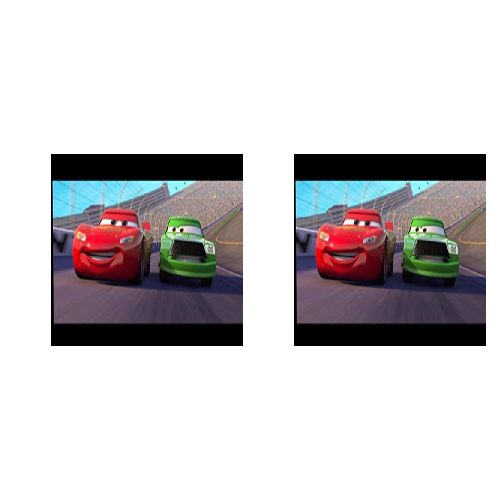

<IPython.core.display.Javascript object>


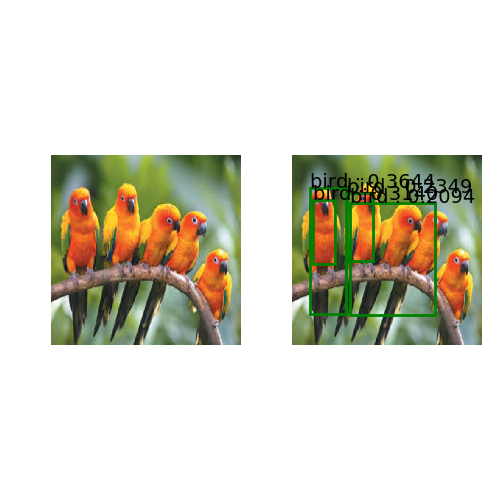

[ 50.192516   105.30084    101.93632    256.43527      0.31400582] bird
[1.2956245e+02 8.9705795e+01 1.9112558e+02 2.4947876e+02 2.3491988e-01] bird
[4.27635651e+01 7.60716095e+01 1.27368324e+02 3.73531219e+02
 3.64365995e-01] bird
[1.3776735e+02 1.1162653e+02 3.3738943e+02 3.7807932e+02 2.0935322e-01] bird


<IPython.core.display.Javascript object>


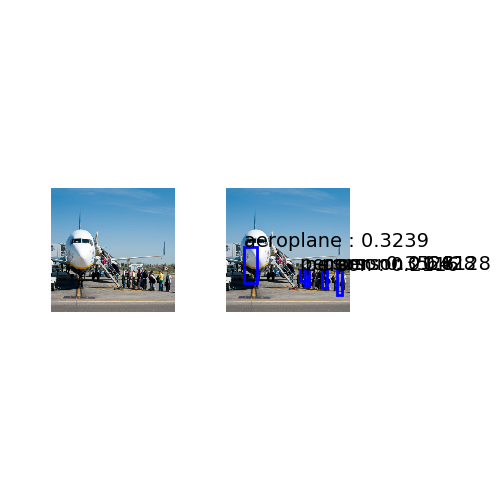

[6.44832382e+01 2.13794861e+02 1.13545334e+02 3.43620300e+02
 3.23937416e-01] aeroplane
[269.91626    297.05652    299.57468    334.70984      0.35257488] person
[2.8827594e+02 2.9788434e+02 3.0288098e+02 3.5553232e+02 2.1158516e-01] person
[350.36282  297.18192  367.02393  361.96405    0.642843] person
[401.52942    297.83142    421.57257    388.3632       0.81277806] person


<IPython.core.display.Javascript object>


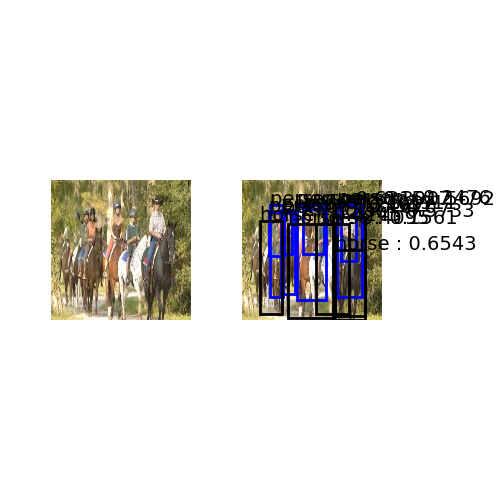

[ 86.42657    100.17353    133.86653    244.21176      0.24909781] person
[1.2948535e+02 1.0381945e+02 1.5848164e+02 2.3525996e+02 1.6697326e-01] person
[1.9514885e+02 9.0764030e+01 2.6105087e+02 2.3689001e+02 1.9105758e-01] person
[318.04767     78.305305   365.10458    258.04547      0.56918705] person
[ 87.693565    78.17386    131.36546    375.16586      0.63146466] person
[1.25491684e+02 9.44140701e+01 1.69110733e+02 3.64999695e+02
 2.05671579e-01] person
[1.7624797e+02 7.8383453e+01 2.6812537e+02 3.8424097e+02 3.0168098e-01] person
[3.0498242e+02 7.7541786e+01 3.8514804e+02 3.7302328e+02 2.4764594e-01] person
[ 57.112442  130.8112    127.52573   430.06406     0.6244924] horse
[1.4753497e+02 1.4047096e+02 2.9693948e+02 4.4206094e+02 4.0945464e-01] horse
[2.3498755e+02 1.4149416e+02 3.4182065e+02 4.2708783e+02 1.5606092e-01] horse
[289.30496    116.283966   393.0934     448.           0.57332295] horse
[295.75897    222.06511    393.62915    435.66647      0.65425855] horse


<IPython.core.display.Javascript object>


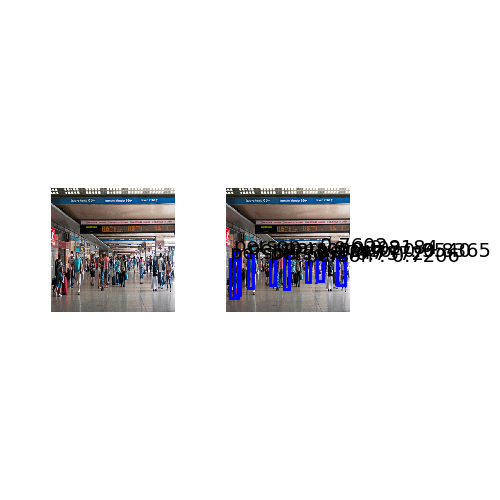

[ 26.991505  229.66779    50.724297  385.58502     0.7601508] person
[ 78.671906  241.54472    98.54082   362.09793     0.9302488] person
[160.68817    258.08435    178.46182    351.82745      0.75719213] person
[210.03511    237.42001    229.4263     365.03265      0.81837094] person
[288.9842     265.1428     302.78412    339.70386      0.72058177] person
[330.89148    249.70078    352.1358     336.5329       0.95404595] person
[400.06805    250.08408    428.94104    350.25836      0.83649254] person
[1.56419735e+01 2.55643448e+02 4.33022842e+01 3.98542999e+02
 3.74706417e-01] person


<IPython.core.display.Javascript object>


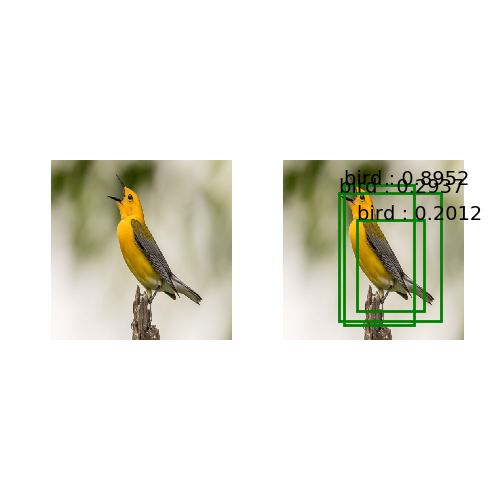

[153.27692     62.589336   325.92053    409.46573      0.89519197] bird
[1.3893729e+02 8.1042709e+01 3.9429373e+02 4.0006757e+02 2.9368511e-01] bird
[1.8522673e+02 1.4971326e+02 3.5119586e+02 3.7436752e+02 2.0123614e-01] bird


<IPython.core.display.Javascript object>


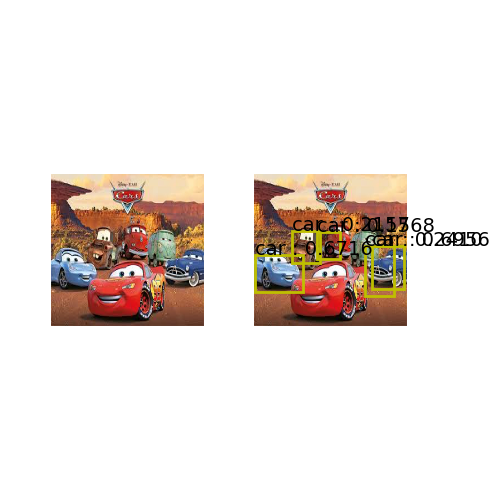

[1.1106889e+02 1.6889207e+02 1.9221236e+02 2.6208603e+02 2.1570383e-01] car
[1.8370323e+02 1.7023677e+02 2.5304259e+02 2.4893195e+02 1.5680176e-01] car
[  0.7147093  237.18172    143.80797    345.9974       0.67158836] car
[3.2543167e+02 2.1189299e+02 4.1272195e+02 3.5855035e+02 2.4095251e-01] car
[347.88455   211.45616   441.36813   337.15106     0.6956048] car


<IPython.core.display.Javascript object>


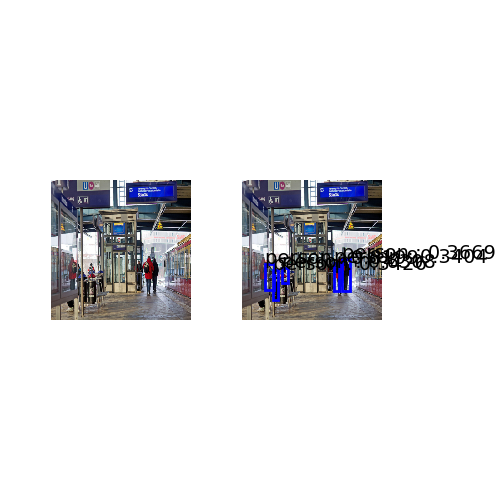

[ 74.202484  268.68756   103.517746  350.5963      0.8199155] person
[128.52704   280.46127   147.36365   328.01135     0.6307951] person
[2.9611700e+02 2.6535858e+02 3.1261319e+02 3.5478946e+02 3.4037536e-01] person
[321.04868    252.70851    347.69608    354.50052      0.36691254] person
[9.9797913e+01 2.8837286e+02 1.1669059e+02 3.8382126e+02 3.4261283e-01] person


<IPython.core.display.Javascript object>


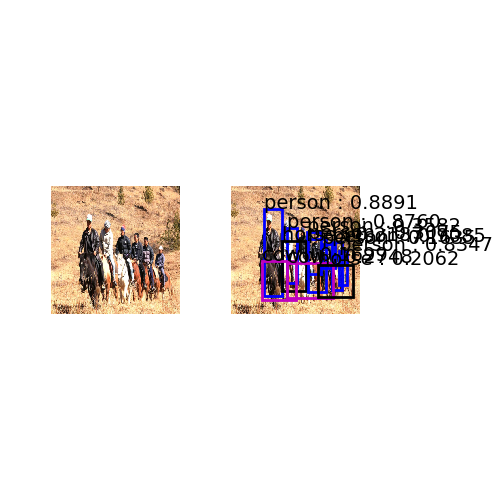

[114.37804     80.69522    178.12697    385.45526      0.88905096] person
[194.36757    148.05676    232.45718    340.06052      0.87600434] person
[264.70807    162.40826    315.2674     306.0017       0.35820183] person
[3.1653717e+02 2.0375194e+02 3.6249310e+02 2.8670517e+02 1.6350771e-01] person
[1.7977817e+02 1.9290074e+02 2.6380624e+02 3.6576141e+02 2.1865356e-01] horse
[2.6800861e+02 1.8409053e+02 3.3317090e+02 3.7035315e+02 3.0746371e-01] person
[352.8907     197.06834    386.10516    361.73315      0.90849453] person
[376.19427    225.32129    406.354      346.6064       0.83473575] person
[1.0863139e+02 2.6156873e+02 2.2778021e+02 3.9718811e+02 1.6994990e-01] cow
[1.9507907e+02 2.6932660e+02 3.5622305e+02 3.9167017e+02 2.7481228e-01] cow
[3.0501215e+02 2.7655902e+02 4.2626959e+02 3.8736966e+02 2.0619695e-01] horse


<IPython.core.display.Javascript object>


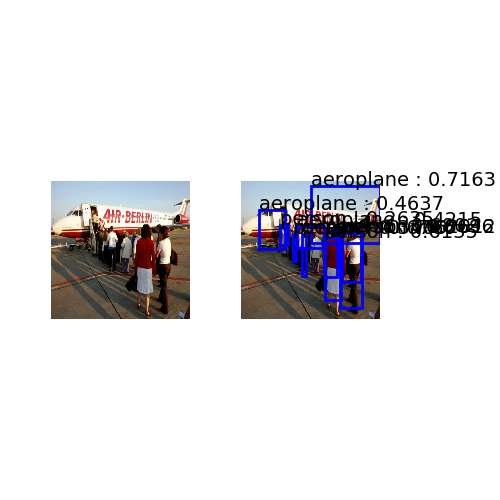

[226.55579    15.415186  448.        200.49803     0.7163268] aeroplane
[ 57.62933     94.19439    141.52638    220.42844      0.46369612] aeroplane
[123.89608    141.65929    150.8764     205.9365       0.26347587] person
[181.42947    146.28442    266.65018    218.09334      0.42145902] aeroplane
[167.32106    171.23434    176.70708    260.10876      0.34060302] person
[197.12845   172.35645   210.25822   308.53766     0.6760498] person
[265.97256   185.4383    307.92526   309.5021      0.6135325] person
[3.2377606e+02 1.6843253e+02 3.8534500e+02 3.2798587e+02 2.0121841e-01] person
[270.56754    165.38554    323.35187    383.70428      0.68023807] person
[318.79492   167.05377   389.88242   410.42685     0.8695611] person


<IPython.core.display.Javascript object>


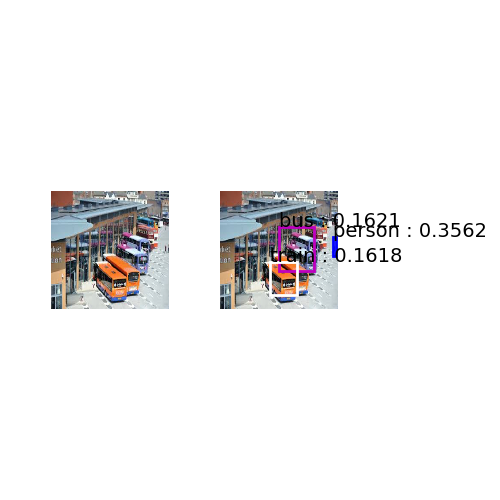

[2.2266141e+02 1.3515115e+02 3.5528857e+02 3.0293784e+02 1.6213310e-01] bus
[4.2920270e+02 1.7312807e+02 4.3972861e+02 2.4684456e+02 3.5620132e-01] person
[1.8736038e+02 2.6995044e+02 2.9128122e+02 3.9307803e+02 1.6177820e-01] train


<IPython.core.display.Javascript object>


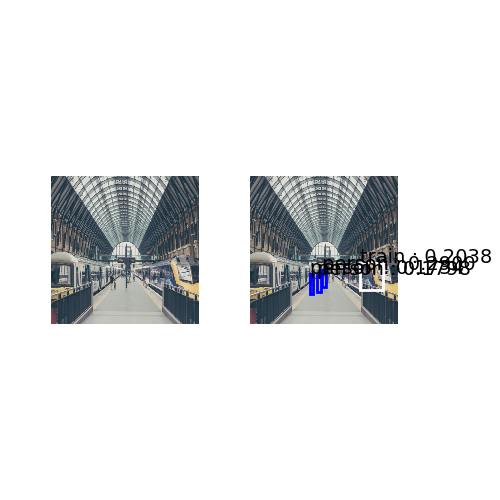

[2.1830200e+02 2.8489304e+02 2.3225645e+02 3.3581799e+02 2.9003155e-01] person
[3.3388055e+02 2.6187595e+02 4.0492770e+02 3.4494922e+02 2.0375477e-01] train
[1.8206047e+02 2.9534238e+02 1.9234549e+02 3.5582349e+02 1.7336427e-01] person
[2.0388156e+02 2.9870642e+02 2.1532976e+02 3.5236099e+02 1.7976922e-01] person


<IPython.core.display.Javascript object>


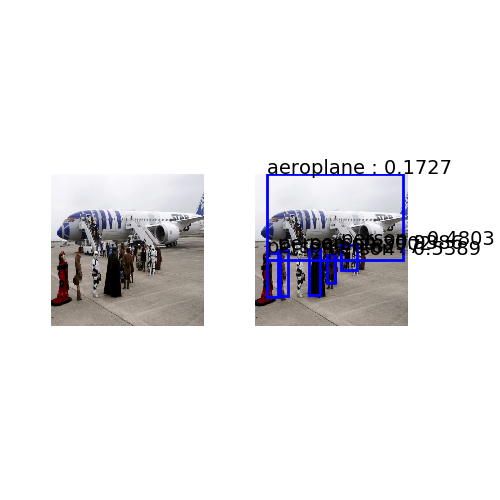

[3.5005806e+01 0.0000000e+00 4.3342230e+02 2.5182237e+02 1.7274770e-01] aeroplane
[252.44952    209.42131    298.93784    281.48773      0.48026845] person
[ 34.559956  233.15952    71.61395   359.78363     0.8277175] person
[ 68.134674   222.24557     96.12807    358.25055      0.39023796] person
[157.1144     219.47055    188.44542    356.20477      0.93864375] person
[211.01413   238.52023   233.23546   319.3324      0.5388661] person


<IPython.core.display.Javascript object>


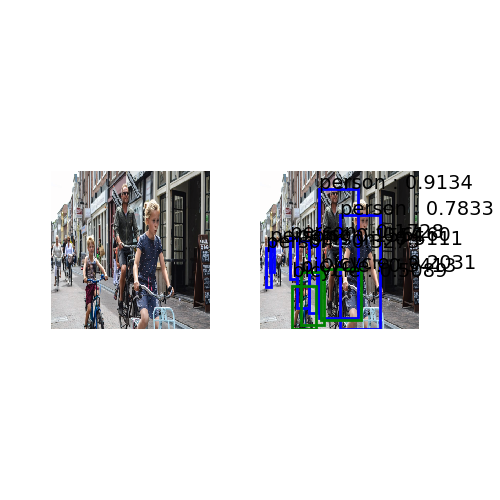

[2.5788881e+01 2.0179863e+02 3.7847290e+01 2.8678412e+02 1.5540221e-01] person
[8.4251877e+01 1.9046527e+02 1.0313130e+02 3.0524979e+02 1.7276071e-01] person
[164.29346     49.970795   275.23114    415.54047      0.91342556] person
[1.5996810e+01 2.1913730e+02 2.9855457e+01 3.2801477e+02 3.2725820e-01] person
[102.93505   197.5009    137.94186   387.66147     0.6160376] person
[137.23929    210.72787    159.44621    402.09467      0.51109815] person
[224.79633    123.067986   336.73346    448.           0.78331906] person
[1.1540384e+02 2.8486389e+02 1.7845828e+02 4.3454938e+02 3.4128669e-01] bicycle
[1.7076070e+02 2.7673401e+02 2.8463107e+02 4.2111304e+02 2.0309176e-01] bicycle
[ 87.51587    324.32483    155.9278     448.           0.50888324] bicycle


<IPython.core.display.Javascript object>


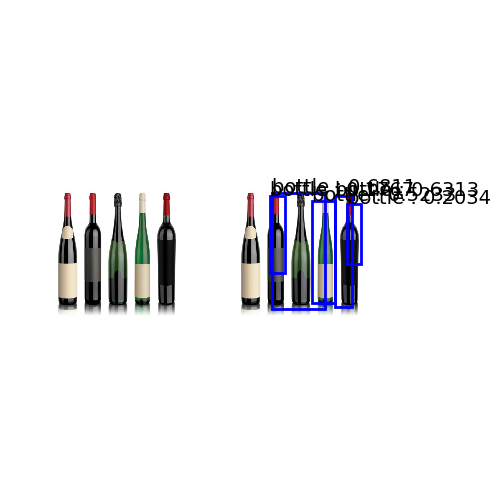

[1.22769325e+02 3.95389175e+01 1.73414246e+02 3.01382660e+02
 1.76743209e-01] bottle
[3.8477066e+02 6.7897133e+01 4.3021927e+02 2.7146719e+02 2.0339763e-01] bottle
[130.60239    30.042837  308.1137    423.78226     0.6811365] bottle
[266.07605     56.607025   341.99448    403.9897       0.52334124] bottle
[343.92523    39.24565   402.51248   418.37646     0.6312732] bottle


<IPython.core.display.Javascript object>


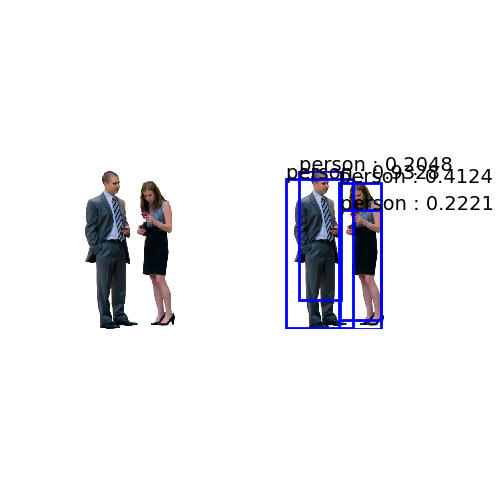

[1.0946878e+02 0.0000000e+00 2.2902457e+02 3.6551761e+02 2.0478630e-01] person
[ 73.010826    21.912464   263.56842    445.87518      0.93277574] person
[2.2343597e+02 3.2010384e+01 3.4447565e+02 4.4800000e+02 4.1244119e-01] person
[2.2719580e+02 1.1008891e+02 3.4447479e+02 4.2221796e+02 2.2206508e-01] person


<IPython.core.display.Javascript object>


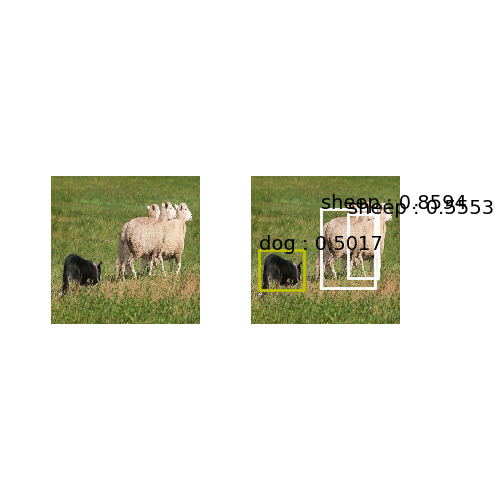

[210.29337    101.02034    373.00348    336.83673      0.85944176] sheep
[292.0119    114.587006  381.811     307.23138     0.5553377] sheep
[ 23.954361  224.59253   160.09908   345.0284      0.5017247] dog


<IPython.core.display.Javascript object>


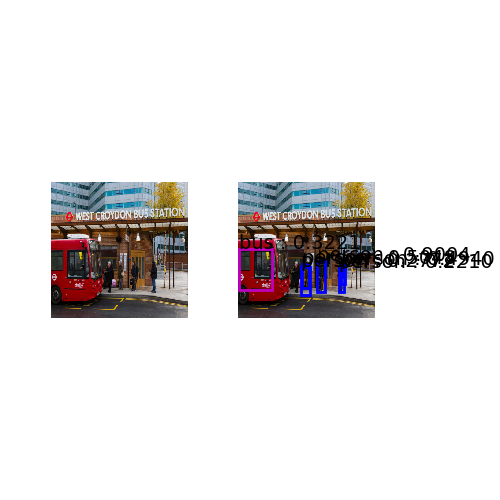

[2.1567984e+00 2.2118875e+02 1.1058958e+02 3.5375867e+02 3.2207590e-01] bus
[210.0094    269.81458   232.50897   347.25604     0.5047737] person
[260.16095   258.30127   285.68686   360.33368     0.9003717] person
[338.25082    272.73416    351.11636    334.41226      0.49400872] person
[2.0689430e+02 2.7847803e+02 2.3592053e+02 3.7034100e+02 2.7723512e-01] person
[3.3316708e+02 2.8440637e+02 3.4724185e+02 3.6292438e+02 2.2102724e-01] person


<IPython.core.display.Javascript object>


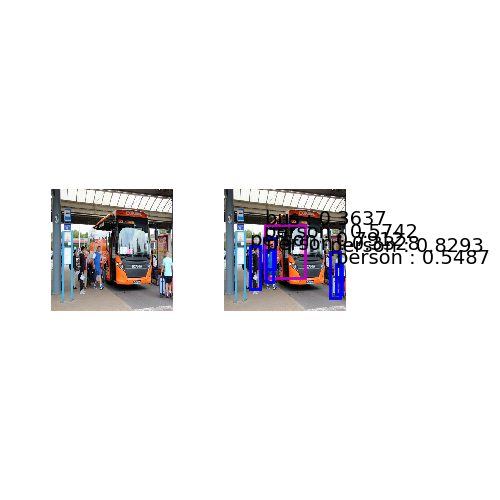

[147.10439   178.70245   184.53004   294.60226     0.5742279] person
[150.45992    132.60025    297.8911     327.43512      0.36370763] bus
[ 92.83753    207.6174     129.72757    367.22543      0.79121435] person
[1.5475372e+02 2.2289041e+02 1.7688950e+02 3.4093729e+02 3.3282259e-01] person
[387.39038   229.24925   423.68265   398.55536     0.8293028] person
[408.85455   274.71313   430.55304   384.23685     0.5486536] person


<IPython.core.display.Javascript object>


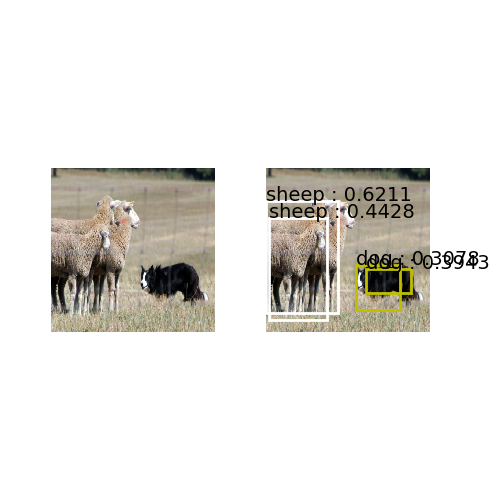

[  0.         89.64061   196.78336   395.77344     0.6211062] sheep
[  9.325447   136.11192    166.11424    414.7863       0.44281054] sheep
[2.7387082e+02 2.7625369e+02 3.9608578e+02 3.4088043e+02 3.9427590e-01] dog
[2.4750438e+02 2.6378271e+02 3.6774832e+02 3.8648459e+02 3.0780897e-01] dog


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


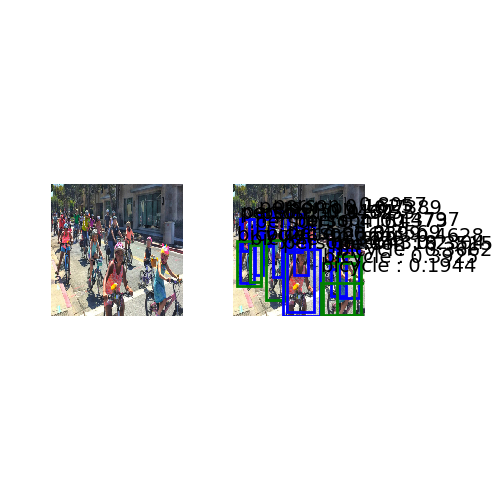

[ 87.72398    95.997795  103.478004  143.85347     0.1625347] person
[ 27.642738   115.688736    54.058865   226.64423      0.41305745] person
[ 94.69966    118.798904   124.29386    209.12898      0.57554543] person
[185.42714   100.62468   234.96414   231.16196     0.7389436] person
[247.86124    142.3248     274.6494     219.33257      0.47973323] person
[ 23.469625   117.39534     69.8876     336.19556      0.34023562] person
[ 72.89527    149.74734    102.38839    307.2553       0.41614705] person
[133.64554    91.31073   165.4957    316.56927     0.8057165] person
[208.67778    144.5452     256.48502    309.21503      0.43732953] person
[329.57834   197.60233   354.3413    287.09314     0.4627627] person
[1.2402707e+01 1.9396899e+02 9.3918877e+01 3.4808914e+02 2.5635883e-01] bicycle
[5.6528625e+01 2.0806770e+02 9.3645218e+01 3.3432016e+02 3.1248590e-01] bicycle
[1.10817635e+02 1.90905838e+02 1.71887131e+02 3.93305603e+02
 3.39949042e-01] bicycle
[1.8188214e+02 1.8480963e+02 2.767

In [12]:
net.eval()
with torch.no_grad():
#     for i in range(1):
    for i in range(len(files)):
        file_name = files[i]

        path_to_file = os.path.join(input_dir,file_name)
        img = Image.open(path_to_file).convert('RGB')

        transform = tv.transforms.Compose([
            tv.transforms.Resize((448, 448)),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        ])

        img = transform(img).to(device)

        output = net.forward(img.view(-1,3,448,448))
        output_bboxes, output_labels = from_prediction_to_bndboxes(output, conf_threshold)
        img_mod = image_transform(img.to('cpu'))

        fig, axs = plt.subplots(nrows =1 , ncols=2, figsize=(5, 5))
        plot_single_image(output_bboxes, output_labels, axs[1])
        axs[0].axis('off')
        axs[1].axis('off')
        axs[0].imshow(img_mod)
        axs[1].imshow(img_mod)
        plt.tight_layout()
        fig.canvas.draw()

#         fig.savefig(os.path.join(input_dir, file_name[:-4]+'_result.png'), \
#                                  bbox_inches='tight', pad_inches = 0)